In [56]:
from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType

# from sentinelhub import BBox, CRS
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rasterio

from eolearn.core import SaveToDisk, LoadFromDisk, EOTask, EOPatch, OverwritePermission
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature, DEMWCSInput, S2L2AWCSInput, L8L1CWCSInput, ExportToTiff

In [2]:
# # reference time

# date_first_start = '2019-04-18'
# date_first_end = '2019-04-20'

# date_last_start = '2019-08-21'
# date_last_end = '2019-08-22'

In [3]:
class NormalBurningRatio(EOTask):
    """
    NBR = (9 - 12)/(9 + 12)
    DNBR = NBR_2 - NBR_1
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        nbr = (band_a - band_b)/(band_a + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, nbr[..., np.newaxis])

        return eopatch    

In [4]:
roi_bbox = BBox(bbox=[27.48, 51.75, 27.57, 51.64], crs=CRS.WGS84)

In [5]:
layer = 'BANDS-S2-L1C'

custom_script = 'return [B04, B08, B08A, B09, B11, B12];'
input_task = S2L1CWCSInput(
    layer=layer,
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='20m', # resolution x
    resy='20m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

add_ndvi = S2L1CWCSInput(layer='NDVI')

add_nbr = NormalBurningRatio('NBR', 'BANDS/3','BANDS/5')

tiff_location = './predicted_tiff_D'

add_dem = DEMWCSInput(layer='DEM')

#add_l2a = S2L2AWCSInput(layer='BANDS-S2-L2A')

add_sen2cor = AddSen2CorClassificationFeature('SCL', layer='BANDS-S2-L2A')

save = SaveToDisk('io_example', overwrite_permission=2, compress_level=1)

In [6]:
%%time

time_interval = ('2019-04-10', '2019-04-21')
workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

Wall time: 37.2 s


In [7]:
eopatch = result[save]
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(4, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(4, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(4, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-04-10', '2019-04-21')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 4, 11, 9, 17, 27), ..., datetime.datetime(2019, 4, 21, 9, 31, 57)], length=4
)

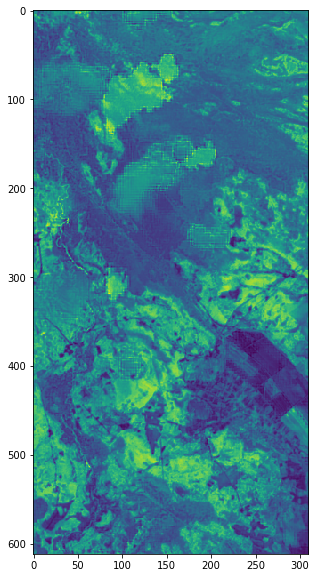

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['NBR'][3].squeeze());

In [9]:
%%time

time_interval = ('2019-05-31', '2019-06-09')
workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result_new = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

Wall time: 34.8 s


In [10]:
eopatch_new = result_new[save]
eopatch_new

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(4, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(4, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(4, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-05-31', '2019-06-09')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 5, 31, 9, 16, 10), ..., datetime.datetime(2019, 6, 8, 9, 26, 1)], length=4
)

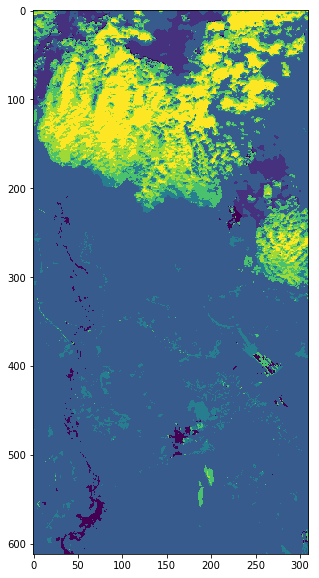

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch_new.mask['SCL'][3].squeeze());

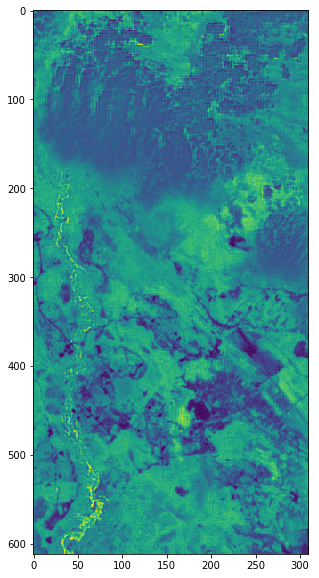

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(eopatch_new.data['NBR'][3].squeeze());

In [13]:
delta_nbr = eopatch.data['NBR'] - eopatch_new.data['NBR']
delta_nbr_1 = eopatch_new.data['NBR'] - eopatch.data['NBR']

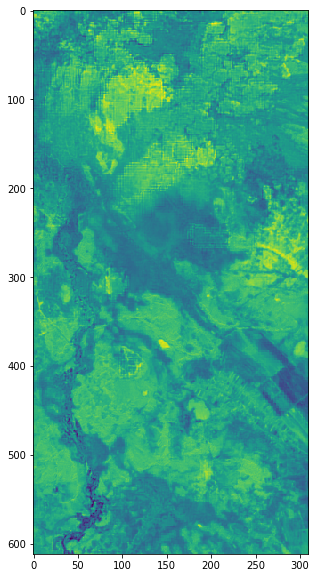

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr[3].squeeze());

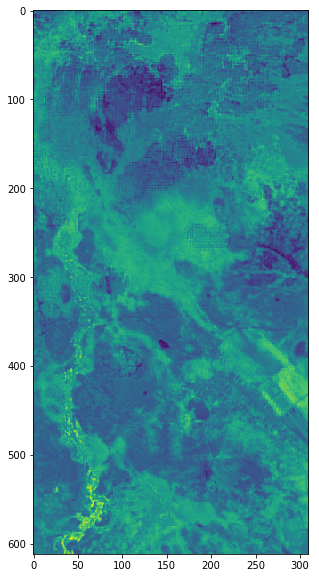

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr_1[3].squeeze());

In [16]:
result_patch = EOPatch()
result_patch[FeatureType.DATA]['dNBR'] = delta_nbr_1

In [17]:
result_patch

EOPatch(
  data: {
    dNBR: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

In [32]:
eopatch.save('./result_patch', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [33]:
patch2 = EOPatch.load('./result_patch')

In [34]:
patch2

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(4, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
    dNBR: numpy.ndarray(shape=(4, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(4, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(4, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-04-10', '2019-04-21')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 4, 11, 9, 17, 27), ..., datetime.datetime(2019, 4, 21, 9, 31, 57)], length=4


In [69]:
# array of shape (h, w)
dst_shape = delta_nbr_1.shape
bbox=[27.48, 51.75, 27.57, 51.64]

# bbox is the bounding box BBox instance used in Wms/WcsRequest 
dst_transform = rasterio.transform.from_bounds(*roi_bbox.get_lower_left(), *roi_bbox.get_upper_right(),
                                               width=dst_shape[1], height=dst_shape[0])
dst_crs = 'EPSG:4326'
# dst_crs = {'init': CRS.ogc_string(bbox.crs)}

# Write it out to a file.
with rasterio.open('result_file.tif', 'w', driver='GTiff',
                              width=dst_shape[1], height=dst_shape[0],
                              count=1, dtype=np.uint8, nodata=0,
                              transform=dst_transform, crs=dst_crs) as dst:
    dst.write(delta_nbr_1.astype(np.uint8))
      

ValueError: Source shape (4, 612, 310, 1) is inconsistent with given indexes 1

In [68]:
# # TASK TO EXPORT TIFF
# load = EOPatch.load('./result_patch')

# export_tiff = ExportToTiff((FeatureType.DATA, 'NBR'))
# tiff_location = './result_tiff'
# if not os.path.isdir(tiff_location):
#     os.makedirs(tiff_location)
    
# execution_args = [{'load' : {'eopatch_folder': 'result_patch'}, 
#                   'export_tiff': {'filename': '{}/result_tiff_{}.tiff'.format(tiff_location, i)}}]   
    
# workflow_export = LinearWorkflow(load, export_tiff)    

# executor = EOExecutor(workflow_export, execution_args)            
# executor.run(workers=2, multiprocess=False)
# executor.make_report()

In [26]:
result_export = workflow_export.execute()

TypeError: During execution of task ExportToTiff: from_bounds() argument after * must be an iterable, not NoneType

In [47]:
for i in range(1,2):
    print(i)

1
